In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d                                  #3D繪圖
from matplotlib.colors import ListedColormap                      #建立colormap，指定每個cluster要塗甚麼顏色
from sklearn.preprocessing import StandardScaler                  #把資料做標準化
from sklearn.model_selection import train_test_split              #用來把原始樣本拆成訓練資料與測試資料
from sklearn.metrics.pairwise import pairwise_distances_argmin    #找出距離最接近的資料的index

################################################################################################################################
#以下定義一些圖示化模型時所需的方法
################################################################################################################################

#此方法是假設第0類的資料中心會被正確判斷
#然後我們把該資料與第0個資料互換位置
def Data_rearrangement(X,y):
    X=np.array(X)
    y=np.array(y)
    n_features=len(list(X[0]))
    #找出第0類資料的中心(平均)
    X0=X[y==0]
    X0Center=[]
    for column in range(n_features):
        X0Center+=[np.array(X[:,column][y==0]).mean()]
    X0Center=np.array(X0Center).reshape(1,-1)
    Number=pairwise_distances_argmin(X0Center,X0)   #這裡回傳的number是X[y==0]的index，並不是在原本X裡面的index
    Index=pairwise_distances_argmin(X0[Number],X)   #找出最接近中心的資料位置
    #交換資料位置
    X[0],X[Index]=X[Index],X[0]
    y[0],y[Index]=y[Index],y[0]
    return Index
################################################################################################################################
#此方法是假設第0類的資料中，距離其他類資料中心最遠的那一個資料
#也就是與其他資料中心的距離和為最大者，會被正確判斷
#然後我們把該資料與第0個資料互換位置
def Data_rearrangement_farthest(X,y):
    X=np.array(X)
    y=np.array(y)
    n_samples=len(list(X))
    n_features=len(list(X[0]))
    n_clusters=y.max()+1
    #找出各類資料的中心(平均)(第0類除外)
    Xmean=np.array(X[0,:]).reshape(1,-1)    #資料初始化，而且資料形狀要調整
    for cluster in range(1,n_clusters):     #第0類資料不用算進去
        mean=X[0,:]                         #資料初始化
        for column in range(n_features):
            mean[column]=np.array(X[:,column][y==cluster]).mean()
        mean=np.array(mean).reshape(1,-1)   #調整資料形狀
        Xmean=np.concatenate((Xmean,mean),axis=0)
    Xmean=np.array(Xmean[1:])               #第0列不要
    #找出第0類的每個資料與各資料中心的距離和
    Distance=[0 for index in range(n_samples)]
    for index in range(n_samples):
        if(y[index]==0):                    #只需要找第0類資料與其他中心的距離和
            Sum=0
            for cluster in range(1,n_clusters):
                distance=0
                for column in range(n_features):
                    distance+=(X[index,column]-Xmean[cluster-1,column])**2
                Sum+=np.sqrt(distance)
            Distance[index]=Sum
    Distance=np.array(Distance)
    #找出距離和最大的資料其相對應的index
    Max=Distance.max()
    Index=-1
    for index in range(n_samples):
        if(Distance[index]==Max):
            Index=index
            break
    #交換資料位置
    X[0],X[Index]=X[Index],X[0]
    y[0],y[Index]=y[Index],y[0]
    return Index
################################################################################################################################
#這個函數會把分類標籤以遞增順序重新整理，而且相同的分類就會對應到相同的數字
#此方法是建立在第0個資料有正確判斷
#如果第0個資料是判斷錯誤的，那麼此方法也會跟著出錯
def Label_redesignation(y):
    n_samples=len(list(y))
    n_clusters=np.array(y).max()+1
    Y=[None for index in range(n_samples)]
    #找出分類標準=0
    Y[0]=0 #第0個資料的分類數字定義為0
    for index in range(1,n_samples):
        if(y[index]==y[0]):
            Y[index]=0
    #找出其他分類標準
    used_label=[y[0]]                       #紀錄已使用過的label
    for label in range(1,n_clusters):       #0號分類已使用過
        Index=-1                            #初始化Index
        for index in range(1,n_samples):
            if(y[index] not in used_label): #檢查y[index]是否為已使用過的label
                Index=index                 #記錄當下的index
                used_label+=[y[Index]]      #記錄當下的實際label
                break
        for index in range(Index,n_samples):
            if(y[index]==y[Index]):
                Y[index]=label
    return np.array(Y)
################################################################################################################################
def Difference_coloring(Y,Y_predict,color_same="lightgray",color_different="red"):
    n_samples=len(list(Y))
    color_list=[]
    for index in range(n_samples):
        if(np.abs(Y[index]-Y_predict[index])<1):
            color_list+=[color_same]
        else:
            color_list+=[color_different]
    return color_list

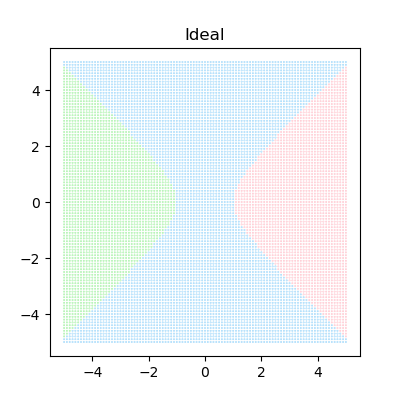

In [2]:
#做出理論範本
xrange=np.linspace(-5,5,101)
yrange=np.linspace(-5,5,101)
XX,YY=np.meshgrid(xrange,yrange)
background=np.array([XX.ravel(),YY.ravel()]).T
label=[]
for coordinate in background:
    if((coordinate[0]**2-coordinate[1]**2>1) and (coordinate[0]>0)):
        label+=[0]
    elif((coordinate[0]**2-coordinate[1]**2>1) and (coordinate[0]<0)):
        label+=[1]
    else:
        label+=[2]
label=np.array(label)
MyColor=ListedColormap(["lightpink", "lightgreen", "lightskyblue"])
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.scatter(background[:,0],background[:,1],c=label,cmap=MyColor,s=0.1)
ax.set_title("Ideal")
#從裡面隨機挑選五千筆資料
random_pick=np.random.randint(low=0,high=background.shape[0],size=5000)
Xpick=background[random_pick]
ypick=label[random_pick]
#把資料分成訓練資料與測試資料
X_train,X_test,y_train,y_test=train_test_split(Xpick,ypick,test_size=0.2,random_state=0)

In [3]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#交換資料位置
index_train=Data_rearrangement_farthest(X_train,y_train)
X_train[0],X_train[index_train]=X_train[index_train],X_train[0]
y_train[0],y_train[index_train]=y_train[index_train],y_train[0]
index_test=Data_rearrangement_farthest(X_test,y_test)
X_test[0],X_test[index_test]=X_test[index_test],X_test[0]
y_test[0],y_test[index_test]=y_test[index_test],y_test[0]
#建立模型
Models={
    "SGDC":SGDClassifier(loss="log_loss",alpha=1e-2,penalty="elasticnet",l1_ratio=0.5,learning_rate="invscaling",eta0=0.1,power_t=0.75,max_iter=10000),
    "DecisionTree":DecisionTreeClassifier(),
    "NaiveBayes":GaussianNB(),
    "linearSVC":SVC(kernel="linear"),
    "polySVC":SVC(kernel="poly",degree=5,C=100,coef0=10),
    "rbfSVC":SVC(kernel="rbf"),
    "sigmoidSVC":SVC(kernel="sigmoid",C=1e-1,gamma="scale"),
    "KNN":KNeighborsClassifier(n_neighbors=5)
}
#訓練模型並檢視訓練成果
scores={}
for name in Models:
    Models[name].fit(X_train,y_train)
    scores[(name,"train score")]=Models[name].score(X_train,y_train)
    scores[(name,"test score")]=Models[name].score(X_test,y_test)
Scores=pd.Series(scores).unstack()
print(Scores)
#以遞增順序重新命名分類數字
#y_test_relabelling=Label_redesignation(y_test)
y_test_relabelling=y_test
y_test_labels={}
for name in Models:
    #y_test_predict=Label_redesignation(Models[name].predict(X_test))
    y_test_predict=Models[name].predict(X_test)
    y_test_labels[name]=y_test_predict

              test score  train score
DecisionTree       0.979      0.99975
KNN                0.987      0.99000
NaiveBayes         0.841      0.84325
SGDC               0.770      0.77675
linearSVC          0.774      0.77900
polySVC            0.998      0.99975
rbfSVC             0.984      0.98250
sigmoidSVC         0.470      0.48900


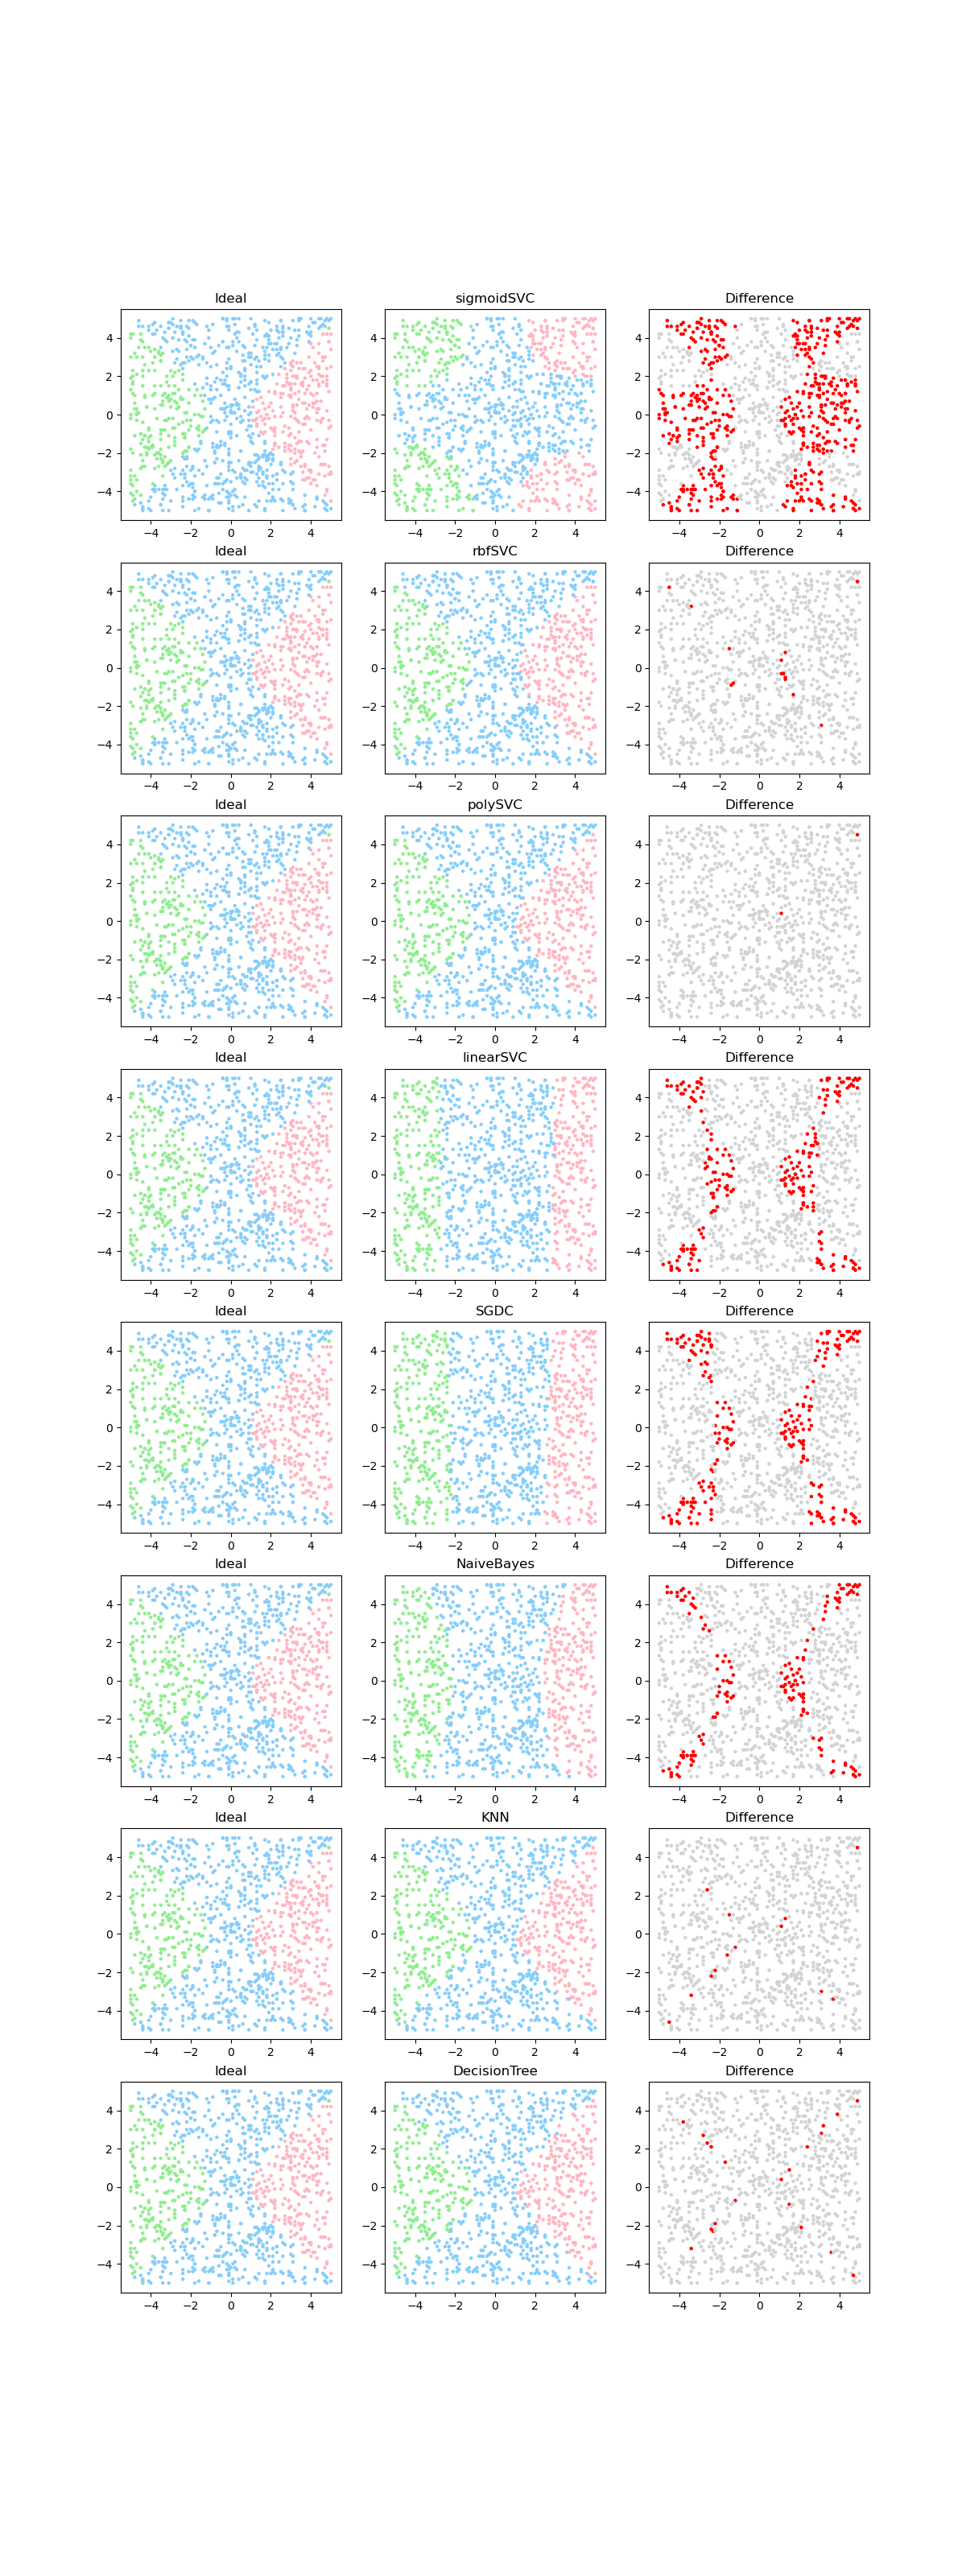

In [4]:
#預測結果圖示化
def NumToName(n):
    if(n==0):
        return "sigmoidSVC"
    elif(n==1):
        return "rbfSVC"
    elif(n==2):
        return "polySVC"
    elif(n==3):
        return "linearSVC"
    elif(n==4):
        return "SGDC"
    elif(n==5):
        return "NaiveBayes"
    elif(n==6):
        return "KNN"
    else:
        return "DecisionTree"
MyColor=ListedColormap(["lightpink","lightgreen","lightskyblue"])
fig,axs=plt.subplots(8,3,figsize=(12,32))
for i in range(24):
    if(i%3==0):
        axs[i//3][i%3].scatter(X_test[:,0],X_test[:,1],c=y_test_relabelling,cmap=MyColor,s=5)
        axs[i//3][i%3].set_title("Ideal")
    elif(i%3==1):
        axs[i//3][i%3].scatter(X_test[:,0],X_test[:,1],c=y_test_labels[NumToName(i//3)],cmap=MyColor,s=5)
        axs[i//3][i%3].set_title(NumToName(i//3))
    else:
        color_list=Difference_coloring(y_test_relabelling,y_test_labels[NumToName(i//3)])
        axs[i//3][i%3].scatter(X_test[:,0],X_test[:,1],c=color_list,s=5)
        axs[i//3][i%3].set_title("Difference")